In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# **R1.1: Single Product Stochastic Environment (No Budget)**

Single product pricing with stochastic demand and no budget constraints.

## Buyer Model

Buyer with Gaussian valuations N(0.5, 1.0). Purchases if price is below valuation.

In [2]:
class Buyer:
  def __init__(self, mu=0.5, sigma=1.0):
    self.mu = mu        # Mean of the valuation distribution
    self.sigma = sigma  # Standard deviation of the valuation distribution

  def round(self, price):
    valuation = np.random.normal(self.mu, self.sigma)   # Draw a valuation from the normal distribution
    return price if price < valuation else 0            # Return price if it's less than the valuation, otherwise return 0

## Company Strategy: UCB1

Classic Upper Confidence Bound algorithm for single product pricing without budget constraints.

In [3]:
class CompanyUCB1:
  def __init__(self, price_set, T, range_factor=1):
    self.P = price_set
    self.K = len(price_set)     # Number of price options
    self.T = T
    self.range = range_factor

    self.t = 0                  # Current time step
    self.p_t = None             # Index of chosen price at time t

    self.average_rewards = np.zeros(self.K)     # Average rewards for each price
    self.N_pulls = np.zeros(self.K)             # Count of times each price has been used

  def set_price(self):
    if self.t < self.K:     # Try each price once initially
      self.p_t = self.t
    else:                   # Compute UCB for each arm
      ucbs = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T) / self.N_pulls)
      self.p_t = np.argmax(ucbs)
    return self.p_t

  def update(self, reward):
    self.N_pulls[self.p_t] += 1   # Increment the count for the chosen price
    n = self.N_pulls[self.p_t]
    self.average_rewards[self.p_t] += (reward - self.average_rewards[self.p_t]) / n # Update the average reward for the chosen price
    self.t += 1                   # Increment the time step

## Simulation

UCB1 learns optimal price p* = 0.5 that maximizes expected revenue p(1-p).

In [4]:
# Price grid 
P = np.linspace(0, 1, 11)
T = 10000

# Expected demand under Gaussian

mu, sigma = 0.5, 1.0
conversion_probability = lambda p: 1 - norm.cdf(p, loc=mu, scale=sigma)
expected_rewards = P * conversion_probability(P)

# Best expected price and profit
best_price_index = np.argmax(expected_rewards)
best_price = P[best_price_index]
expected_clairvoyant_reward = expected_rewards[best_price_index] * T
expected_clairvoyant_rewards = np.repeat(expected_rewards[best_price_index], T)

print(f"Best price (expected): {best_price:.2f}")
print(f"Expected clairvoyant total reward: {expected_clairvoyant_reward:.2f}")

n_trials = 10
regret_per_trial = []

for seed in range(n_trials):  # Set a different seed for each trial
  np.random.seed(seed)

  buyer = Buyer()
  agent = CompanyUCB1(P, T)
  agent_rewards = np.array([])

  for _ in range(T):  # For each time step
    idx = agent.set_price()
    selected_price = agent.P[idx]         # Get the price to set
    reward = buyer.round(selected_price)  # Get the reward from the buyer

    agent.update(reward)                  # Update the agent with the received reward
    agent_rewards = np.append(agent_rewards, reward)

  cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards) # Calculate cumulative regret
  regret_per_trial.append(cumulative_regret)                                

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)  # Average regret across trials
regret_std = regret_per_trial.std(axis=0)       # Standard deviation of regret across trials

Best price (expected): 0.90
Expected clairvoyant total reward: 3101.20


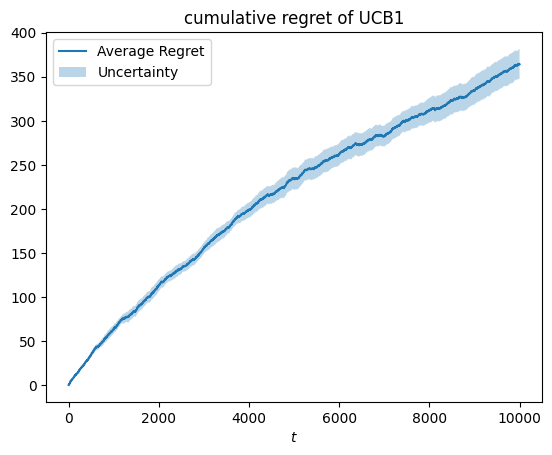

In [6]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret - regret_std / np.sqrt(n_trials),
                average_regret + regret_std / np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

## Results

Sublinear regret achieved with $O(T^{2/3})$ bound.

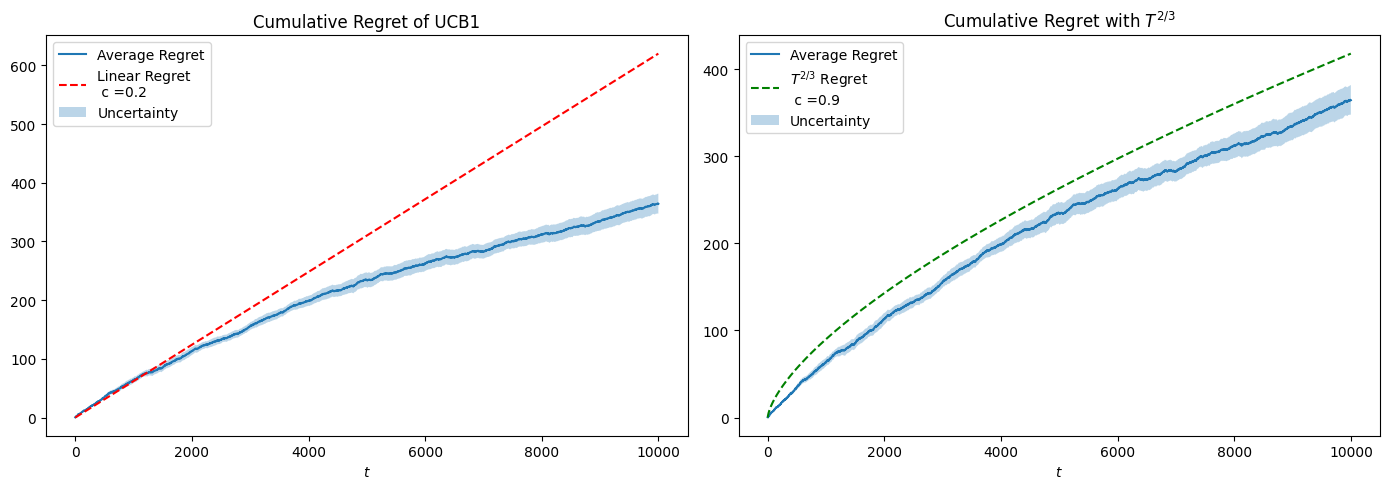

In [9]:
fig, axs = plt.subplots(1,2, figsize=(14 , 5))

# First subplot: Cumulative regret with linear line
axs[0].plot(np.arange(T), average_regret, label='Average Regret')
axs[0].set_title('Cumulative Regret of UCB1')

c_linear = 0.2
linear_regret = np.arange(T) * (expected_clairvoyant_reward / T) * c_linear
axs[0].plot(np.arange(T), linear_regret, label=f'Linear Regret \n c ={c_linear}', linestyle='--', color='red')

axs[0].fill_between(np.arange(T),
                    average_regret - regret_std / np.sqrt(n_trials),
                    average_regret + regret_std / np.sqrt(n_trials),
                    alpha=0.3,
                    label='Uncertainty')

axs[0].set_xlabel('$t$')
axs[0].legend()

# Second subplot: Cumulative regret with x^(2/3) line
axs[1].plot(np.arange(T), average_regret, label='Average Regret')
axs[1].set_title('Cumulative Regret with $T^{2/3}$')

c=0.9
x_2_3_regret = np.arange(T) ** (2/3) * c
axs[1].plot(np.arange(T), x_2_3_regret, label='$T^{2/3}$'+ f' Regret \n c ={c}', linestyle='--', color='green')

axs[1].fill_between(np.arange(T),
                    average_regret - regret_std / np.sqrt(n_trials),
                    average_regret + regret_std / np.sqrt(n_trials),
                    alpha=0.3,
                    label='Uncertainty')

axs[1].set_xlabel('$t$')
axs[1].legend()

plt.tight_layout()
plt.show()